In [104]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os

params = {"ytick.color" : "w",
          "xtick.color" : "w",
          "axes.labelcolor" : "w",
          "axes.edgecolor" : "y",
          "axes.facecolor" : "None",
          "text.color" : 'w'}
plt.rcParams.update(params)




In [105]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory= 'data/coffee_samples/',
    labels='inferred',
    label_mode='int', 
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset="training"
)




Found 1813 files belonging to 2 classes.
Using 1451 files for training.


In [106]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory= 'data/coffee_samples/',
    labels='inferred',
    label_mode='int', 
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset="validation"
)


Found 1813 files belonging to 2 classes.
Using 362 files for validation.


In [107]:
class_names = train_ds.class_names
print(class_names)

['bad', 'good']


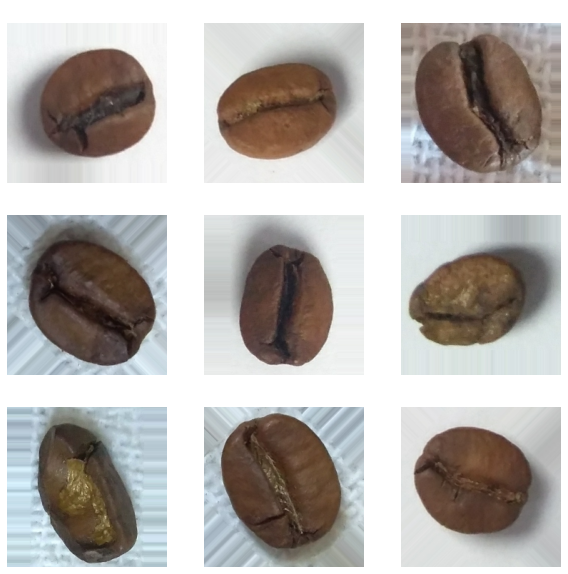

In [108]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [109]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)


In [110]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 


0.044140495 0.94611174


In [111]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [112]:
base_model = tf.keras.applications.MobileNet(
    weights="imagenet",  # load weights pretrained on the ImageNet
    input_shape=(224, 224, 3),
    include_top=False  # do not include the ImageNet classifier at the top
)
# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = tf.keras.Input(shape=(224, 224, 3))
# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(inputs)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = tf.keras.layers.Dense(2)(x)

model_mobilenet = tf.keras.Model(inputs, outputs, name='pretrained_mobilenet')

model_mobilenet.summary()

Model: "pretrained_mobilenet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenet_1.00_224 (Function (None, 7, 7, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d_6 ( (None, 1024)              0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 2050      
Total params: 3,230,914
Trainable params: 2,050
Non-trainable params: 3,228,864
_________________________________________________________________


In [113]:
model_mobilenet.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

model_dir = "mobilenet/"


In [114]:
callbacks_list_mobilenet = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(model_dir, "weights" + "_epoch_{epoch}"),
        monitor="loss",
        save_best_only=True,
        save_weights_only=True,
        verbose=1,
    )
]

Epoch 1/15
46/46 [==============================] - ETA: 0s - loss: 0.5117 - accuracy: 0.7636 

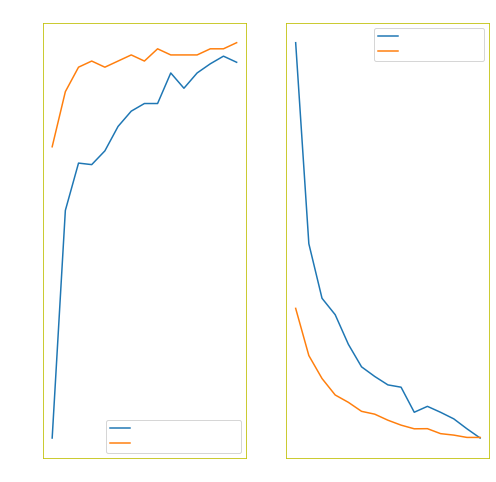

OSError: Unable to create file (unable to open file: name = 'models/mobilenet_for_coffe_class.h5', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 602)

In [115]:

try:
    model_mobilenet = tf.keras.models.load_model(filepath='models/mobilenet_for_coffe_class.h5')
except:
    EPOCHS = 15
    history = model_mobilenet.fit(
        train_ds,
        epochs=EPOCHS,
        callbacks=callbacks_list_mobilenet,
        validation_data=val_ds)
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(EPOCHS)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()
    model_mobilenet.save(filepath='models/mobilenet_for_coffe_class.h5', include_optimizer=False)

In [ ]:
class_names = np.array(class_names)

In [ ]:
image_batch, label_batch = next(iter(train_ds.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

In [ ]:
image_batch.shape

In [ ]:
predicted_batch = model_mobilenet.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_ids = predicted_ids.astype(int)
predicted_class_names = class_names[predicted_ids]

In [ ]:
print("Labels: ", label_batch)
print("Predicted labels: ", predicted_ids)

In [ ]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n].astype(np.uint8))
  color = "white" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")
